2.0.2
making  awi0005x3s_xtc.fits  into a text file 

Filename: awi0005x3s_xtc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     128   (2034, 4, 6)   float32   
None
(6L, 4L, 2034L)
test: (4L, 2034L)
[ 1.88225853  1.88254631  1.88283408 ...,  2.46527195  2.46555972
  2.46584749]
[             nan              nan   7.95202948e-16 ...,   4.19596299e-16
   4.08960001e-16   4.35063200e-16]
SIMPLE  =                    T / Written by IDL:  Tue Mar 27 21:32:19 2018      
BITPIX  =                  -32 /  IEEE single precision floating point          
NAXIS   =                    3 /                                                
NAXIS1  =                 2034 / Number of positions along axis 1               
NAXIS2  =                    4 / Number of positions along axis 2               
NAXIS3  =                    6 / Number of positions along axis 3               
FILENAME= 'AWI0005x3s_test_comb.fits' /                                

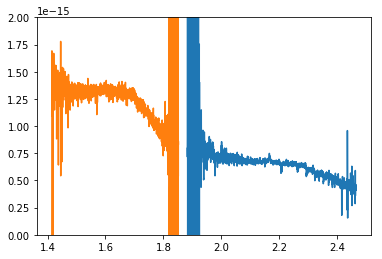

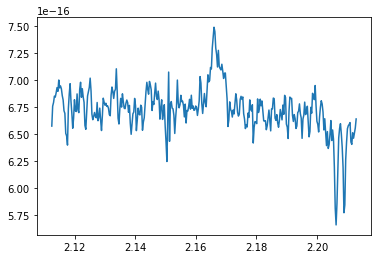

In [62]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import glob, os
from pprint import pprint
import astropy
print astropy.__version__

for file in glob.glob('awi0005x3s_xtc.fits'):
    print 'making ', file, ' into a text file \n'
    hdulist = fits.open(file)
    print hdulist.info()
    spectra = hdulist[0].data
    oldheader = hdulist[0].header
    print spectra.shape
    #xwave_order3 = spectra[:,0,0]
    #xdata_order3 = spectra[:,1,0]
    #xerror_order3 = spectra[:,2,0]
    
    test = spectra[0,:,:]
    print 'test:', test.shape
    
    test1 = spectra[0,0,:]
    #print 'test1:',test1.shape
    #print min(test1), max(test1)
    test2 = spectra[0,1,:]
    #print min(test2), max(test2)
    print test1[0:2029]
    print test2[0:2029]
    
    xwave_order3 = spectra[0,0,0:2029]
    xdata_order3 = spectra[0,1,0:2029]
    
    xwave_order4 = spectra[1,0,0:2029]
    xdata_order4 = spectra[1,1,0:2029]
    
    pprint(oldheader)
    print len(xwave)
    print len(xdata)
    F = open(file[:-5] + '_IRAF.txt','w')
    for j in range(0,len(xwave)):
        F.write(str(xwave[j]) + ' ' + str(xdata[j]) + '\n')
    F.close()

    plt.figure()
    plt.plot(xwave_order3, xdata_order3)
    plt.plot(xwave_order4, xdata_order4)
    plt.ylim([0., 2.e-15])
    plt.show()
    
    #print xwave_order3[800]
    #print xwave_order3[1150]
    
    plt.figure()
    plt.plot(xwave_order3[800:1150], xdata_order3[800:1150])
    plt.show()
